# Sequence to Sequence Learning with Neural Networks [1]

## Part 2. 모델 훈련과 실험

# Training Details from the Paper

- 인코더 (encoder) 와 디코더 (decoder) 로 각각 4계층 LSTM (LSTM with four layers) 를 사용하였다. ✅
- 입력 시퀀스의 순서를 반대로 하였다. ✅
- 입력 언어와 출력 언어의 단어 집합을 고정하였다. 입력 언어에서는 빈번하게 쓰이는 단어 순으로 160,000개의 단어를, 출력 언어에서는 빈번하게 쓰이는 단어 순으로 80,000개의 단어를 선택하였다. 해당 집합에 없는 단어들은 모두 "UNK" 토큰으로 교체하였다. ✅ *(단, 두 단어 집합의 크기가 다르다. 입력 단어 집합의 크기는 약 80,000, 출력 단어 집합의 크기는 약 60,000이다.)*
- 빔 검색 (beam search) 을 사용하였다. 빔의 크기가 1일 때도 잘 동작하였으나, 빔의 크기가 2일 때 가장 효율적으로 좋은 결과를 얻을 수 있었다. ❌
- embed_size = 10,000, hidden_size = 10,000 ✅ *(단, 데이터셋과 입출력 단어 집합의 크기가 모두 상대적으로 작은 것을 감안하여 각각 512로 낮추었다.)*
- 출력 시에 나이브 소프트맥스 (naive softmax) 를 사용하여 확률을 얻었다. ❌ *(손실 함수를 선택하는 것이 어려워 생략하였다.)*
- 모든 파라미터는 -0.08과 0.08 사이의 범위에서 균등 분포로 초기화하였다. ✅
- 학습률을 0.7로 고정하여 SGD를 모멘텀 없이 사용하였다. 5 에폭 이후부터 반 에폭마다 학습률을 반감하였으며 총 7.5 에폭 동안 훈련하였다. ❌ *(Adam을 사용하였다. Adam의 경우 학습률을 따로 감소하지 않아도 되기 때문에 학습률을 변경하지 않았다.)*
- batch_size = 128 ❌ *(데이터셋의 크기가 작아 자주 업데이트하는 것이 좋을 것 같아 64로 줄였다.)*
- 기울기 폭주 문제 (exploding gradient problem) 에 대처하기 위해 그래디언트의 크기가 임계값 (논문에서는 5) 을 넘을 경우 크기를 조절하였다. ✅
- 각 배치에 있는 시퀀스의 길이가 유사하도록 배치들을 구성하였으며, 이를 통해 더 빠르게 학습시킬 수 있었다. ❌

# Training

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

import math
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device:', device)

Current device: cuda


## Load & Process the Data

In [ ]:
# Download spaCy models for tokenization
!python -m spacy download en
!python -m spacy download de

In [4]:
# Import Libraries
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [5]:
# Pre-defined tokens
UNK_TOKEN = '<unk>' # token representing "unknown word"
PAD_TOKEN = '<pad>' # token representing "padding"
SOS_TOKEN = '<sos>' # token representing "start of sentence"
EOS_TOKEN = '<eos>' # token representing "end of sentence"

In [ ]:
src_tokenizer = get_tokenizer(tokenizer='spacy', language='de')
trg_tokenizer = get_tokenizer(tokenizer='spacy', language='en')

def yield_src_tokens(data):
  for src_sentence, _ in data:
    yield src_tokenizer(src_sentence.strip().lower())

def yield_trg_tokens(data):
  for _, trg_sentence in data:
    yield trg_tokenizer(trg_sentence.strip().lower())

# Build a vocabulary for German
train_data = Multi30k(split=('train'), language_pair=('de', 'en'))
src_vocab = build_vocab_from_iterator(yield_src_tokens(train_data), min_freq=2, specials=[UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
src_vocab.set_default_index(src_vocab[UNK_TOKEN]) # set the unknown token '<unk>' as default

# Build a vocabulary for English
train_data = Multi30k(split=('train'), language_pair=('de', 'en'))
trg_vocab = build_vocab_from_iterator(yield_trg_tokens(train_data), min_freq=2, specials=[UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_vocab.set_default_index(trg_vocab[UNK_TOKEN]) # set the unknown token '<unk>' as default

In [7]:
print(f'Vocabulary size for German: {len(src_vocab)}')
print(f'Vocabulary size for English: {len(trg_vocab)}')

Vocabulary size for German: 7855
Vocabulary size for English: 5894


In [8]:
# A function to process each batch
def collate_fn(batch):
  src_list, trg_list = [], []
  for src_sentence, trg_sentence in batch:
    src_tokens = src_tokenizer(src_sentence.strip().lower())
    src_indices = src_vocab([SOS_TOKEN] + src_tokens + [EOS_TOKEN])
    src_list.append(torch.tensor(src_indices[::-1], dtype=torch.long)) # reversed!

    trg_tokens = trg_tokenizer(trg_sentence.strip().lower())
    trg_indices = trg_vocab([SOS_TOKEN] + trg_tokens + [EOS_TOKEN])
    trg_list.append(torch.tensor(trg_indices, dtype=torch.long))
  
  src_tensor = pad_sequence(src_list, padding_value=src_vocab[PAD_TOKEN])
  trg_tensor = pad_sequence(trg_list, padding_value=trg_vocab[PAD_TOKEN])
  return src_tensor, trg_tensor

In [ ]:
from torchtext.data.functional import to_map_style_dataset
BATCH_SIZE = 64

train_data, val_data, test_data = Multi30k(split=('train', 'valid', 'test'), language_pair=('de', 'en'))

train_data = to_map_style_dataset(train_data)
val_data = to_map_style_dataset(val_data)
test_data = to_map_style_dataset(test_data)

# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [10]:
print('Number of the training examples:', len(train_data))
print('Number of the validation examples:', len(val_data))
print('Number of the test examples:', len(test_data))

Number of the training examples: 29000
Number of the validation examples: 1014
Number of the test examples: 1000


## Build the Model

In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

In [12]:
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks

In [ ]:
MODEL_NOTEBOOK_LINK = "https://colab.research.google.com/drive/1WYk8xibj0992zltpeObIQ65IdVTxSjE-"

fcn_id = extract_drive_file_id(MODEL_NOTEBOOK_LINK)
print('Google Drive file id: "%s"' % fcn_id)
register_colab_notebooks({'models': fcn_id})

from models import LSTMLayer, LSTM, Encoder, Decoder, Seq2SeqNetwork
print('Import successful!')

In [14]:
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 4

input_size = len(src_vocab)
output_size = len(trg_vocab)
padding_index = src_vocab.lookup_indices([PAD_TOKEN])[0]

model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)

## Helper Functions

In [15]:
def format_time(start_time, current_time, progress):
  elapsed = int(current_time - start_time)
  elapsed_time = f'{elapsed // 60:2d}m {elapsed % 60:2d}s'
  total = int(elapsed / progress)
  total_time = f'{total // 60:2d}m {total % 60:2d}s'
  return elapsed_time, total_time

In [16]:
# A function for training
def train(dataloader, model, optimizer, loss_fn, verbose=True, print_every=50):
  model.train()
  avg_loss = 0.
  loss_history = []
  model.train()
  for batch, (src, trg) in enumerate(dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = model(src, trg)
    pred = pred[1:].view(-1, pred.size(2))
    trg = trg[1:].view(-1)
    # pred: [trg_len * batch_size, output_size], trg: [trg_len * batch_size]
    loss = loss_fn(pred, trg)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    avg_loss += loss.item()
    loss_history.append(loss.item())
    if verbose and batch % print_every == 0 and batch > 0:
      avg_loss /= print_every
      print(f'> [{(batch + 1) * src.size(1):5d}/{len(dataloader.dataset):5d}]',
            f'loss={avg_loss:1.4f}, ppl={math.exp(avg_loss):7.3f}')
      avg_loss = 0.
    
  return loss_history

In [17]:
# A function for evaluation
def evaluate(dataloader, model, loss_fn, verbose=True):
  avg_loss = 0.
  loss_history = []
  model.eval()
  with torch.no_grad():
    for batch, (src, trg) in enumerate(dataloader):
      src, trg = src.to(device), trg.to(device)
      pred = model(src, trg)
      pred = pred[1:trg.size(0)].view(-1, pred.size(2))
      trg = trg[1:].view(-1)
      # pred: [trg_len * batch_size, output_size], trg: [trg_len * batch_size]
      loss = loss_fn(pred, trg)

      avg_loss += loss.item()
      loss_history.append(loss.item())
  if verbose:
    avg_loss /= len(dataloader)
    print(f'> [evaluation]  loss={avg_loss:1.4f},',
          f'ppl={math.exp(avg_loss):7.3f}')
  return avg_loss, loss_history

## Train the Model

In [26]:
# Hyperparameters
BATCH_SIZE = 64

EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_LAYERS = 4

NUM_EPOCHS = 15
# LEARNING_RATE = 0.001
MAX_GRAD_NORM = 5

In [19]:
# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [20]:
model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)
for param in model.parameters():
  param.data.uniform_(-0.08, 0.08)
print(f'The number of model parameter: {sum([param.numel() for param in model.parameters()]):,}')

The number of model parameter: 33,148,166


In [21]:
# Prepare an optimizer and a loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_index)
# reduction='mean' -> the gradients are summed and divided by batch_size

In [22]:
best_val_loss = float('inf')
train_loss_history = []
val_loss_history = []
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn)
  val_loss_history += loss_history

  if epoch > NUM_EPOCHS // 2 and val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'seq2seq-{val_loss * pow(10, 5):07.0f}.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), epoch / NUM_EPOCHS)
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 1
-----------------------------------------
> [ 3264/29000] loss=5.6506, ppl=284.461
> [ 6464/29000] loss=4.9628, ppl=142.992
> [ 9664/29000] loss=4.9152, ppl=136.342
> [12864/29000] loss=4.8362, ppl=125.994
> [16064/29000] loss=4.8154, ppl=123.398
> [19264/29000] loss=4.7914, ppl=120.472
> [22464/29000] loss=4.6831, ppl=108.101
> [25664/29000] loss=4.7921, ppl=120.551
> [28864/29000] loss=4.9052, ppl=134.991
> [evaluation]  loss=4.6296,  ppl=102.477
-----------------------------------------
End of epoch 1 ( 4m 53s/24m 25s)
-----------------------------------------

-----------------------------------------
Epoch 2
-----------------------------------------
> [ 3264/29000] loss=4.7221, ppl=112.404
> [ 6464/29000] loss=4.5514, ppl= 94.767
> [ 9664/29000] loss=4.5163, ppl= 91.500
> [12864/29000] loss=4.4418, ppl= 84.929
> [16064/29000] loss=4.4688, ppl= 87.253
> [19264/29000] loss=4.4897, ppl= 89.091
> [22464/29000] loss=4.4010, ppl= 81.529


In [25]:
start_time = time.time()
for epoch in range(6, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn)
  val_loss_history += loss_history

  if epoch > NUM_EPOCHS // 2 and val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'seq2seq-{val_loss * pow(10, 5):07.0f}.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), epoch / NUM_EPOCHS)
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 6
-----------------------------------------
> [ 3264/29000] loss=3.4427, ppl= 31.270
> [ 6464/29000] loss=3.2268, ppl= 25.200
> [ 9664/29000] loss=3.1695, ppl= 23.794
> [12864/29000] loss=3.1630, ppl= 23.642
> [16064/29000] loss=3.1678, ppl= 23.755
> [19264/29000] loss=3.3002, ppl= 27.119
> [22464/29000] loss=3.2586, ppl= 26.013
> [25664/29000] loss=3.3328, ppl= 28.016
> [28864/29000] loss=3.5381, ppl= 34.400
> [evaluation]  loss=3.9183,  ppl= 50.317
-----------------------------------------
End of epoch 6 ( 4m 55s/ 8m 11s)
-----------------------------------------

-----------------------------------------
Epoch 7
-----------------------------------------
> [ 3264/29000] loss=3.2727, ppl= 26.382
> [ 6464/29000] loss=3.0784, ppl= 21.725
> [ 9664/29000] loss=2.9957, ppl= 20.000
> [12864/29000] loss=2.9973, ppl= 20.032
> [16064/29000] loss=3.0096, ppl= 20.280
> [19264/29000] loss=3.1585, ppl= 23.536
> [22464/29000] loss=3.0952, ppl= 22.091


In [27]:
start_time = time.time()
for epoch in range(11, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn)
  val_loss_history += loss_history

  if epoch > NUM_EPOCHS // 2 and val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'seq2seq-{val_loss * pow(10, 5):07.0f}.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), epoch / NUM_EPOCHS)
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 11
-----------------------------------------
> [ 3264/29000] loss=2.6803, ppl= 14.590
> [ 6464/29000] loss=2.4700, ppl= 11.822
> [ 9664/29000] loss=2.4664, ppl= 11.780
> [12864/29000] loss=2.4527, ppl= 11.620
> [16064/29000] loss=2.4818, ppl= 11.963
> [19264/29000] loss=2.6364, ppl= 13.962
> [22464/29000] loss=2.6190, ppl= 13.722
> [25664/29000] loss=2.6834, ppl= 14.635
> [28864/29000] loss=2.8821, ppl= 17.852
> [evaluation]  loss=3.7963,  ppl= 44.538
-----------------------------------------
End of epoch 11 ( 5m 20s/ 7m 16s)
-----------------------------------------

-----------------------------------------
Epoch 12
-----------------------------------------
> [ 3264/29000] loss=2.5535, ppl= 12.852
> [ 6464/29000] loss=2.3673, ppl= 10.669
> [ 9664/29000] loss=2.3357, ppl= 10.337
> [12864/29000] loss=2.3508, ppl= 10.494
> [16064/29000] loss=2.3940, ppl= 10.957
> [19264/29000] loss=2.5030, ppl= 12.219
> [22464/29000] loss=2.4797, ppl= 11.9

# Experiments

## Performance on Test Dataset

In [28]:
best_model = Seq2SeqNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, output_size,
                       NUM_LAYERS, padding_index, device=device)
best_model.load_state_dict(torch.load('best-model.pth')) # at epoch 10

<All keys matched successfully>

In [30]:
_ = evaluate(test_dataloader, best_model, loss_fn)

> [evaluation]  loss=3.7525,  ppl= 42.626


## PCA Projection of LSTM Hidden States

In [65]:
src_vocab['mann'], src_vocab['frau']

(13, 16)

In [67]:
data = [
  ('Ein Mann bewundert eine Frau.', 'A man admires a woman.'),
  ('Ein Mann ist in der Liebe zu einer Frau.', 'A man is in love with a woman.'),
  ('Ein Mann respektiert eine Frau.', 'A man respects a woman.'),
  ('Eine Frau bewundert einen Mann.', 'A woman admires a man.'),
  ('Eine Frau ist in der Liebe zu einem Mann.', 'A woman is in love with a man.'),
  ('Eine Frau respektiert einen Mann.', 'A woman respects a man.'),
]

src_tensor, trg_tensor = collate_fn(data)
print(src_tensor.shape)
print(src_tensor)

torch.Size([12, 6])
tensor([[   3,    3,    3,    3,    3,    3],
        [   4,    4,    4,    4,    4,    4],
        [  16,   16,   16,   13,   13,   13],
        [   8,   14,    8,   19,    6,   19],
        [1450,   28,    0, 1450,   28,    0],
        [  13, 4831,   13,   16, 4831,   16],
        [   5,   15,    5,    8,   15,    8],
        [   2,    7,    2,    2,    7,    2],
        [   1,   48,    1,    1,   48,    1],
        [   1,   13,    1,    1,   16,    1],
        [   1,    5,    1,    1,    8,    1],
        [   1,    2,    1,    1,    2,    1]])


In [69]:
output, (hidden, cell) = best_model.encode(src_tensor.to(device))
last_hidden = hidden[best_model.num_rnn_layers-1] # [batch_size, hidden_size]
U, S, V = torch.pca_lowrank(last_hidden)
principal_components = torch.matmul(last_hidden, V[:, :2]) # project into 2D
principal_components.shape

torch.Size([6, 2])

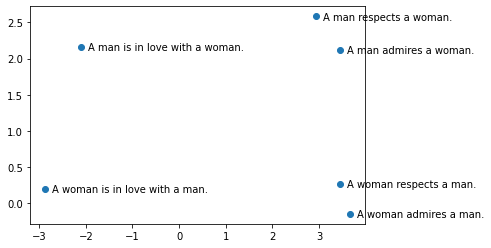

In [70]:
fig, ax = plt.subplots()

x = [principal_components[i, 0].cpu().detach() for i in range(principal_components.size(0))]
y = [principal_components[i, 1].cpu().detach() for i in range(principal_components.size(0))]
ax.scatter(x, y)

# printed in English for understanding but encoded in "German"
for i in range(principal_components.size(0)):
  ax.annotate(data[i][1], (x[i] + 0.15, y[i] - 0.05))

In [74]:
data = [
  ('Ich wurde von ihr im Garten eine Karte erhalten.', 'I was given a card by her in the garden.'),
  ('Im Garten gab sie mir eine Karte.', 'In the garden, she gave me a card.'),
  ('Sie gab mir eine Karte im Garten.', 'She gave me a card in the garden.'),
  ('Ich habe sie im Garten eine Karte erhalten.', 'She was given a card by me in the garden.'),
  ('Im Garten gab ich ihr eine Karte.', 'In the garden, I gave her a card.'),
  ('Ich habe ihr eine Karte im Garten gegeben.', 'I gave her a card in the garden.'),
]

src_tensor, trg_tensor = collate_fn(data)
print(src_tensor.shape)
print(src_tensor)

torch.Size([12, 6])
tensor([[   3,    3,    3,    3,    3,    3],
        [   4,    4,    4,    4,    4,    4],
        [3198, 1632,  674, 3198, 1632,    0],
        [1632,    8,   20, 1632,    8,  674],
        [   8, 6784, 1632,    8,  134,   20],
        [ 674,   99,    8,  674, 1181, 1632],
        [  20,    0, 6784,   20,    0,    8],
        [ 134,  674,    0,   99,  674,  134],
        [  22,   20,   99, 4668,   20, 4668],
        [ 993,    2,    2, 1181,    2, 1181],
        [1181,    1,    1,    2,    1,    2],
        [   2,    1,    1,    1,    1,    1]])


In [75]:
output, (hidden, cell) = best_model.encode(src_tensor.to(device))
last_hidden = hidden[best_model.num_rnn_layers-1] # [batch_size, hidden_size]
U, S, V = torch.pca_lowrank(last_hidden)
principal_components = torch.matmul(last_hidden, V[:, :2]) # project into 2D
principal_components.shape

torch.Size([6, 2])

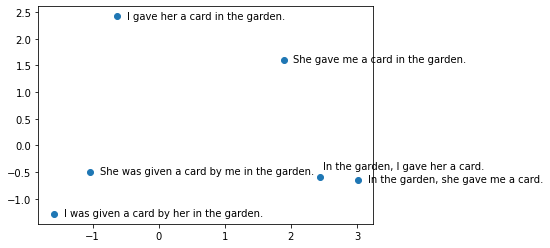

In [77]:
fig, ax = plt.subplots()

x = [principal_components[i, 0].cpu().detach() for i in range(principal_components.size(0))]
y = [principal_components[i, 1].cpu().detach() for i in range(principal_components.size(0))]
ax.scatter(x, y)

# printed in English for understanding but encoded in "German"
for i in range(principal_components.size(0)):
  if i == 4: ax.annotate(data[i][1], (x[i] + 0.05, y[i] + 0.15))
  else: ax.annotate(data[i][1], (x[i] + 0.15, y[i] - 0.05))

## Example Translations

In [46]:
BATCH_SIZE = 5
newtrain_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtrain_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence[::-1]) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
    break

Input German:      zwei junge weiße männer sind im freien in der nähe vieler büsche .
Target English:    two young , white males are outside near many bushes .
Predicted English: <unk> two young black men are standing outside outside outside outside .

Input German:      mehrere männer mit schutzhelmen bedienen ein <unk> .
Target English:    several men in hard hats are operating a giant pulley system .
Predicted English: <unk> several men wearing hats hats are a a a .

Input German:      ein kleines mädchen klettert in ein spielhaus aus holz .
Target English:    a little girl climbing into a wooden playhouse .
Predicted English: <unk> a little girl climbs a a pool .

Input German:      ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster .
Target English:    a man in a blue shirt is standing on a ladder cleaning a window .
Predicted English: <unk> a man in a blue shirt is standing on a a of a .

Input German:      zwei männer stehen am herd und bereiten essen zu 

In [47]:
BATCH_SIZE = 5
newtest_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtest_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence[::-1]) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
    break

Input German:      ein mann mit einem orangefarbenen hut , der etwas <unk> .
Target English:    a man in an orange hat starring at something .
Predicted English: <unk> a man wearing a red hat is his his . .

Input German:      ein boston terrier läuft über <unk> gras vor einem weißen zaun .
Target English:    a boston terrier is running on lush green grass in front of a white fence .
Predicted English: <unk> a brown dog runs down the grass of a white white white building .

Input German:      ein mädchen in einem karateanzug bricht einen stock mit einem tritt .
Target English:    a girl in karate uniform breaking a stick with a front kick .
Predicted English: <unk> a girl in a pool holding holding a ball in a pool .

Input German:      fünf leute in winterjacken und mit helmen stehen im schnee mit <unk> im hintergrund .
Target English:    five people wearing winter jackets and helmets stand in the snow , with <unk> in the background .
Predicted English: <unk> five people in blue and an

# References

[1] Sequence to Sequence Learning with Neural Networks [[link]](
https://doi.org/10.48550/arXiv.1409.3215)